In [1]:
#%%capture
#!pip install rdkit
#!pip install torch_geometric
try:
  import rdkit
except:
  !pip install rdkit
  
try:
  import torch_geometric
except:
  !pip install torch_geometric
  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import networkx as nx
from math import sqrt

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors

import torch.nn.functional as F
from torch.utils.data import random_split

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.nn import AttentiveFP

In [3]:
import os
import random
from collections import Counter

import torch

from torch_geometric.data import InMemoryDataset, download_url, extract_gz
from torch_geometric.utils import from_smiles
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
# print(plt.style.available)
plt.style.use('ggplot')

In [5]:
##A random seed is used to ensure that results are reproducible. 
##In other words, using this parameter makes sure that anyone who re-runs your code will get the exact same outputs. 
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [6]:
seed_set()

## **Loading Dataset**

In [7]:
df = pd.read_csv('Lipophilicity.csv')

In [8]:
df.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


## **Data Analysis**

In [9]:
df.describe()

,exp
count,4200.000000
mean,2.186336
std,1.203004
min,-1.500000
25%,1.410000
50%,2.360000
75%,3.100000
max,4.500000


In [10]:
# make sure there are no duplicates
df['smiles'].nunique()

4200

Text(0, 0.5, 'Count')

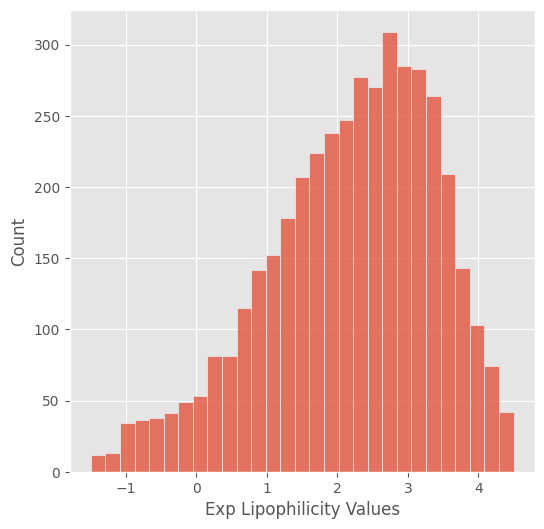

In [11]:
# distribution of exp lipophilicity values

plt.figure(figsize=(6,6))
sns.histplot(data=df, x='exp', y=None, hue=None)
# plt.hist(df['exp'], bins=30)
plt.xlabel('Exp Lipophilicity Values')
plt.ylabel('Count')

In [12]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles', molCol='mol')

In [13]:
df.head()

,CMPD_CHEMBLID,exp,smiles,mol
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f140>
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f060>
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f1b0>
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f220>
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f290>


In [14]:
mwt = []
for mol in df['mol']:
  MW = Descriptors.MolWt(mol)
  mwt.append(MW)

df['molwt'] = mwt

In [15]:
df.head()

,CMPD_CHEMBLID,exp,smiles,mol,molwt
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f140>,340.858
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f060>,494.591
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f1b0>,321.829
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f220>,419.890
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f290>,381.480


Text(0, 0.5, 'Count')

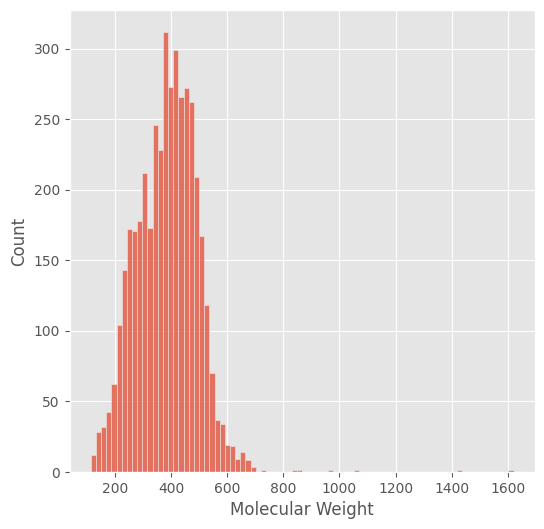

In [16]:
# Distribution of Molecular Weight in Raw Dataset

plt.figure(figsize=(6,6))
sns.histplot(data=df, x='molwt', y=None, hue=None)
# plt.hist(df['exp'], bins=30)
plt.xlabel('Molecular Weight')
plt.ylabel('Count')

In [17]:
high_mwt = df[df['molwt'] > 700]
high_mwt

,CMPD_CHEMBLID,exp,smiles,mol,molwt
364,CHEMBL1094250,3.48,C[C@@H](CNC(=O)c1c(O)c(O)cc2c(O)c(c(C)cc12)c3c...,<rdkit.Chem.rdchem.Mol object at 0x7f49fa9151c0>,700.788
442,CHEMBL1214185,1.80,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,<rdkit.Chem.rdchem.Mol object at 0x7f49fa9173e0>,837.058
905,CHEMBL443684,0.64,CC1(C)CCC(=C(CN2CCN(CC2)c3ccc(cc3)C(=O)NS(=O)(...,<rdkit.Chem.rdchem.Mol object at 0x7f49fa9240b0>,974.634
1236,CHEMBL2170837,4.20,CCn1c(C)c(C(=O)O)c(c2cccc(c2)N3CCN(CC3)c4ccc(N...,<rdkit.Chem.rdchem.Mol object at 0x7f49fa92d230>,1065.703
1397,CHEMBL1200558,-0.46,CC[C@H](C)[C@H](N)C1=N[C@@H](CS1)C(=O)N[C@@H](...,<rdkit.Chem.rdchem.Mol object at 0x7f49fa931930>,1422.720
1646,CHEMBL3545252,3.40,O.O.O.CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@]3(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f49fa938740>,861.935
3592,CHEMBL387675,-0.94,CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f49fa96e180>,1620.693
3780,CHEMBL163,4.30,CC(C)[C@H](NC(=O)N(C)Cc1csc(n1)C(C)C)C(=O)N[C@...,<rdkit.Chem.rdchem.Mol object at 0x7f49fa973450>,720.962


In [18]:
high_mwt.shape

(8, 5)

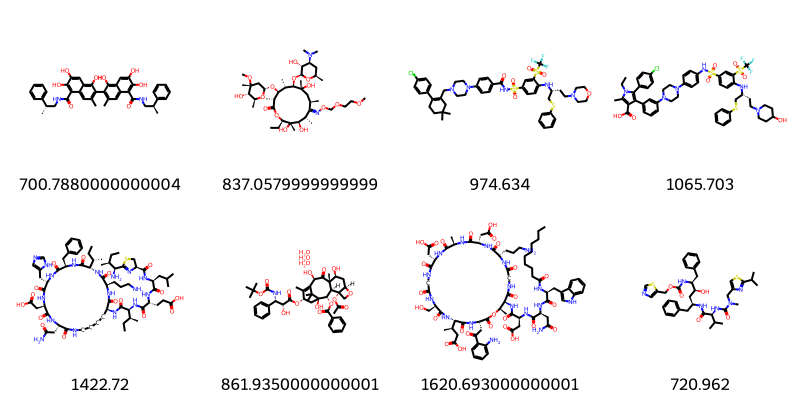

In [19]:
img=Draw.MolsToGridImage(high_mwt['mol'], molsPerRow=4, subImgSize=(200,200),legends=[str(x) for x in high_mwt['molwt']])
img

In [20]:
smiles = high_mwt['smiles']
df_final = df[~df['smiles'].isin(smiles)]

In [21]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles,mol,molwt
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f140>,340.858
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f060>,494.591
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f1b0>,321.829
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f220>,419.890
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f290>,381.480


In [22]:
df_final.shape

(4192, 5)

In [23]:
# df_final = df_final[['CMPD_CHEMBLID', 'exp', 'smiles']]
# df_final.to_csv('Lipophilicity_final.csv', index=None)

Text(0, 0.5, 'Count')

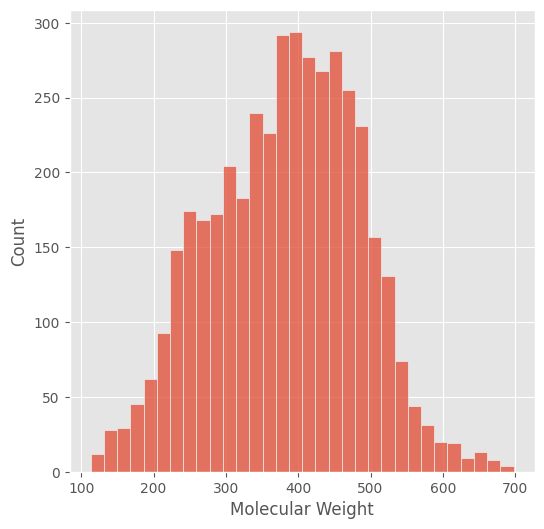

In [24]:
# Distribution of Molecular Weight in Truncated Dataset

plt.figure(figsize=(6,6))
sns.histplot(data=df_final, x='molwt', y=None, hue=None)
# plt.hist(df['exp'], bins=30)
plt.xlabel('Molecular Weight')
plt.ylabel('Count')

In [25]:
df_final = df_final.reset_index(drop=True)

In [26]:
df_final.describe()

,exp,molwt
count,4192.000000,4192.000000
mean,2.186591,381.915338
std,1.201077,102.456833
min,-1.500000,113.160000
25%,1.410000,306.440750
50%,2.360000,388.370500
75%,3.100000,456.576500
max,4.500000,697.778000


In [27]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles,mol,molwt
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f140>,340.858
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f060>,494.591
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f1b0>,321.829
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f220>,419.890
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x7f49f9d3f290>,381.480


In [28]:
unique_atoms = set()
for mol in df_final['mol']:
  for atom in mol.GetAtoms():
    a = atom.GetSymbol()
    unique_atoms.add(a)

In [29]:
unique_atoms

{'B', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'Se', 'Si'}

In [30]:
atom_list = []
for mol in df_final['mol']:
  for atom in mol.GetAtoms():
    a = atom.GetSymbol()
    atom_list.append(a)

In [31]:
Counter(atom_list)

Counter({'C': 83065,
         'N': 14505,
         'O': 10679,
         'F': 1760,
         'S': 1580,
         'Cl': 1288,
         'Br': 100,
         'I': 7,
         'B': 6,
         'P': 3,
         'Si': 1,
         'Se': 1})

In [32]:
dict_ = { 'N': 14505,
         'Cl': 1288,
         'O': 10679,
         'S': 1580,
         'F': 1760,
         'B': 6,
         'Br': 100,
         'P': 3,
         'I': 7,
         'Si': 1,
         'Se': 1}

In [33]:
df_freq = pd.DataFrame(dict_.items(), columns = ['Atoms', 'Count']).sort_values('Count', ascending=False)

In [34]:
df_freq.head()

,Atoms,Count
0,N,14505
2,O,10679
4,F,1760
3,S,1580
1,Cl,1288


/tmp/ipykernel_441696/3828436040.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_freq, x = 'Atoms', y = 'Count', palette = 'Set2')


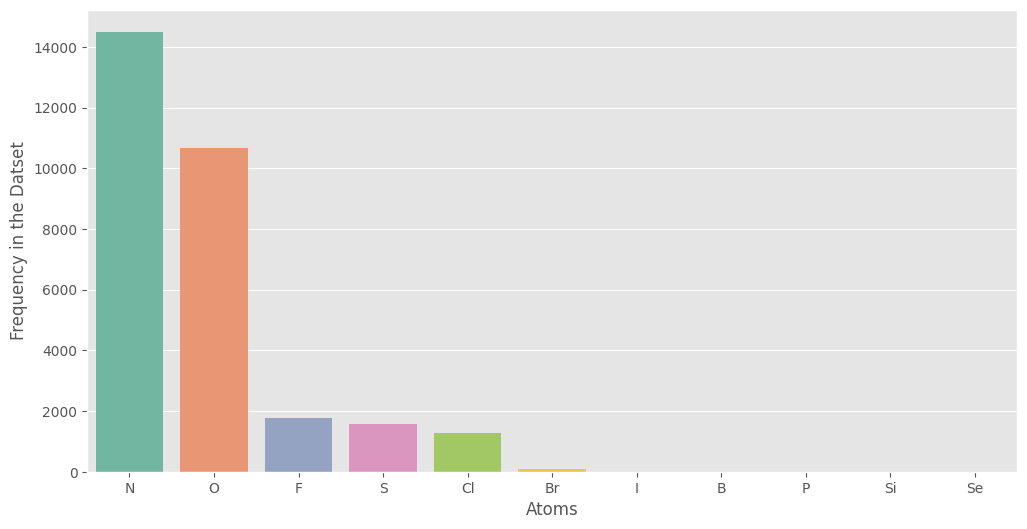

In [35]:
plt.figure(figsize=(12,6))
sns.barplot(df_freq, x = 'Atoms', y = 'Count', palette = 'Set2')
plt.ylabel('Frequency in the Datset')
plt.show()

In [36]:
# b_mols = [Chem.MolFromSmiles(x) for x in b_smiles[-50:]]
# img=Draw.MolsToGridImage(b_mols,molsPerRow=4,subImgSize=(400,400))
# img

In [37]:
atom_list = ['B', 'Br','Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'Se', 'Si']
dict_2 = {}
for i in range(len(atom_list)):
  count=0
  for mol in df_final["mol"]:
    all_atoms = set()
    for atom in mol.GetAtoms():
      a = atom.GetSymbol()
      all_atoms.add(a)
    if atom_list[i] in all_atoms:
      count+=1
    dict_2[atom_list[i]] = count

In [38]:
dict_2

{'B': 6,
 'Br': 96,
 'Cl': 974,
 'F': 899,
 'I': 4,
 'N': 4039,
 'O': 3814,
 'P': 3,
 'S': 1352,
 'Se': 1,
 'Si': 1}

In [39]:
df_freq_2 = pd.DataFrame(dict_2.items(), columns = ['Atoms', 'Count']).sort_values('Count', ascending=False)

/tmp/ipykernel_441696/2956682421.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df_freq_2, x = 'Atoms', y = 'Count', palette = 'Set2')


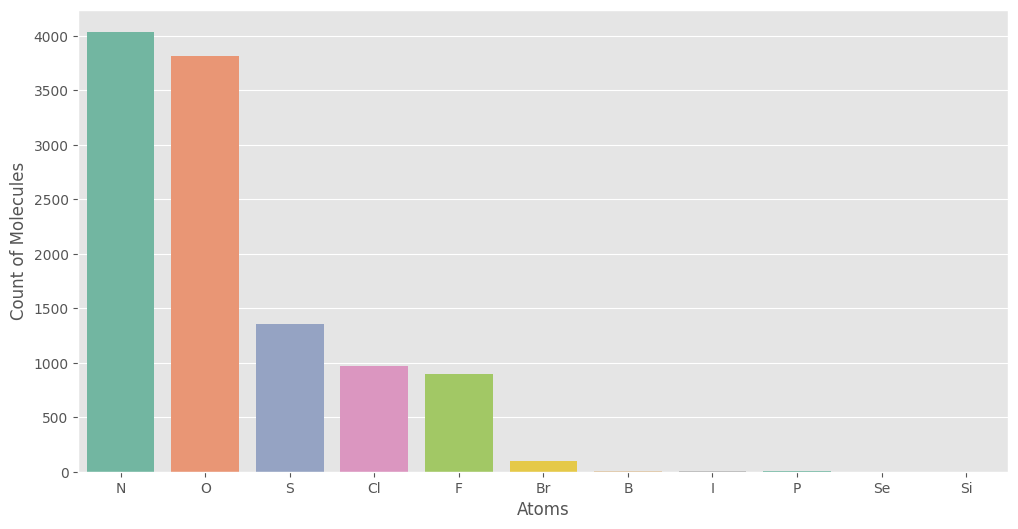

In [40]:
plt.figure(figsize=(12,6))
sns.barplot(df_freq_2, x = 'Atoms', y = 'Count', palette = 'Set2')
plt.ylabel('Count of Molecules')
plt.show()

## **Generating and Analyzing Graphs**

In [41]:
df_final = pd.read_csv('Lipophilicity_final.csv')

In [42]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [43]:
smile = df_final['smiles'][92]

In [44]:
smile

'CN(C)C(=O)c1ccc(CN2CCc3cc4nc(N)sc4cc3CC2)cc1'

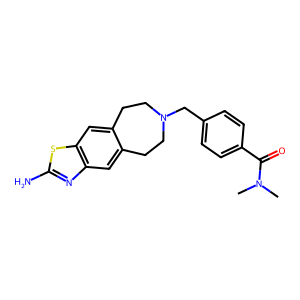

In [45]:
mol = Chem.MolFromSmiles(smile)
img = Draw.MolToImage(mol)
img

In [46]:
g = from_smiles(smile, with_hydrogen=False)
g

Data(x=[27, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CN(C)C(=O)c1ccc(CN2CCc3cc4nc(N)sc4cc3CC2)cc1')

In [47]:
# type(g)

In [48]:
g.x.dtype

torch.int64

In [49]:
g.x

tensor([[ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 7,  0,  3,  5,  0,  0,  3,  0,  0],
        [ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 6,  0,  3,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  0],
        [ 7,  0,  3,  5,  0,  0,  4,  0,  1],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  1],
        [ 6,  0,  4,  5,  2,  0,  4,  0,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 7,  0,  2,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 7,  0,  3,  5,  2,  0,  3,  0,  0],
        [16,  0,  2,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  0,  0,  3,  1,  1],
        [ 6,  0,  3,  5,  1,  0,  

In [50]:
g.num_nodes

27

In [51]:
g.num_node_features

9

In [52]:
g.edge_index

tensor([[ 0,  1,  1,  1,  2,  3,  3,  3,  4,  5,  5,  5,  6,  6,  7,  7,  8,  8,
          8,  9,  9, 10, 10, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15, 15, 15,
         16, 16, 17, 17, 17, 18, 19, 19, 20, 20, 20, 21, 21, 22, 22, 22, 23, 23,
         24, 24, 25, 25, 26, 26],
        [ 1,  0,  2,  3,  1,  1,  4,  5,  3,  3,  6, 26,  5,  7,  6,  8,  7,  9,
         25,  8, 10,  9, 11, 24, 10, 12, 11, 13, 12, 14, 22, 13, 15, 14, 16, 20,
         15, 17, 16, 18, 19, 17, 17, 20, 15, 19, 21, 20, 22, 13, 21, 23, 22, 24,
         10, 23,  8, 26,  5, 25]])

In [53]:
g.edge_attr

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  1],
        [ 1,  0,  0],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [12,  0,  1],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [1

In [54]:
g

Data(x=[27, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CN(C)C(=O)c1ccc(CN2CCc3cc4nc(N)sc4cc3CC2)cc1')

In [55]:
G = to_networkx(g)

In [56]:
type(G)

networkx.classes.digraph.DiGraph

In [57]:
G.number_of_nodes()

27

In [58]:
list(G.nodes)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26]

In [59]:
G.number_of_edges()

60

In [60]:
list(G.edges)

[(0, 1),
 (1, 0),
 (1, 2),
 (1, 3),
 (2, 1),
 (3, 1),
 (3, 4),
 (3, 5),
 (4, 3),
 (5, 3),
 (5, 6),
 (5, 26),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (8, 9),
 (8, 25),
 (9, 8),
 (9, 10),
 (10, 9),
 (10, 11),
 (10, 24),
 (11, 10),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (13, 22),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (15, 20),
 (16, 15),
 (16, 17),
 (17, 16),
 (17, 18),
 (17, 19),
 (18, 17),
 (19, 17),
 (19, 20),
 (20, 15),
 (20, 19),
 (20, 21),
 (21, 20),
 (21, 22),
 (22, 13),
 (22, 21),
 (22, 23),
 (23, 22),
 (23, 24),
 (24, 10),
 (24, 23),
 (25, 8),
 (25, 26),
 (26, 5),
 (26, 25)]

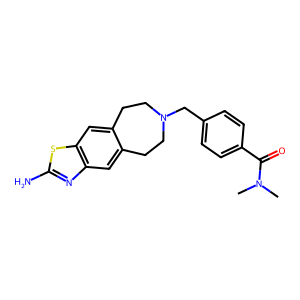

In [61]:
img

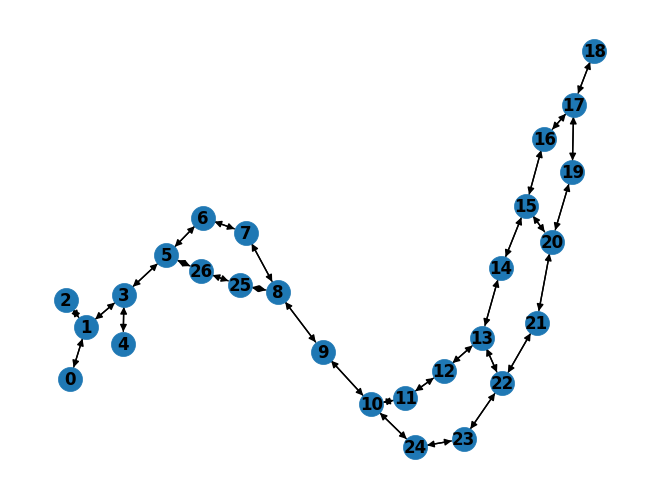

In [62]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.savefig("G.png")

# **Generate Graphs for the Whole Dataset**

In [63]:
df_final.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [64]:
graph_list = []
for i, smile in enumerate(df_final['smiles']):
  g = from_smiles(smile)
  g.x = g.x.float()
  y = torch.tensor(df_final['exp'][i], dtype=torch.float).view(1, -1)
  g.y = y
  graph_list.append(g)

In [65]:
type(graph_list[0])

torch_geometric.data.data.Data

In [66]:
graph_list[1]

Data(x=[33, 9], edge_index=[2, 70], edge_attr=[70, 3], smiles='COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', y=[1, 1])

In [67]:
graph_list[1].y

tensor([[-1.1800]])

In [68]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])
        # For PyG<2.4:
        # self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return 'Lipophilicity.csv'

    @property
    def processed_file_names(self):
        return 'data.dt'

    def download(self):
        # Download to `self.raw_dir`.
        # download_url(url, self.raw_dir)
        pass

    def process(self):
        # Read data into huge `Data` list.
        graph_list = []
        for i, smile in enumerate(df_final['smiles']):
          g = from_smiles(smile)
          g.x = g.x.float()
          y = torch.tensor(df_final['exp'][i], dtype=torch.float).view(1, -1)
          g.y = y
          graph_list.append(g)


        data_list = graph_list

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

In [69]:
lipo = MyOwnDataset(root = '/home/sandeep/gnn/content/')

/home/sandeep/miniconda3/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f) !

In [70]:
type(lipo)

__main__.MyOwnDataset

In [71]:
lipo[23]


Data(x=[31, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OC(=O)c1cccc(c1)N2CCC(CN3CCC(CC3)Oc4ccc(Cl)c(Cl)c4)CC2', y=[1, 1])

In [72]:
lipo[23].y

tensor([[2.1700]])

In [73]:
len(lipo)

4192

## **Train Test Split**

In [74]:
train_ratio = 0.80  # 80% for training, 20% for testing
dataset_size = len(graph_list)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Split the dataset into train and test subsets
generator1 = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(graph_list, [train_size, test_size], generator=generator1)

In [75]:
df_final.iloc[train_dataset.indices]

,CMPD_CHEMBLID,exp,smiles
3654,CHEMBL424451,3.96,COc1ccc(C)c(NC(=O)CC23CC4CC(CC(C4)C2)C3)c1
195,CHEMBL139347,2.40,Nc1nc(N)nc(n1)c2cccc(c2)C(F)(F)F
1988,CHEMBL2158833,1.10,OC(=O)c1ccc(CN2CCC(CN3CCC(CC3)Oc4ccc(Cl)c(Cl)c...
242,CHEMBL1201373,1.07,CC[C@H](C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C...
310,CHEMBL1800526,2.92,COc1ccnc(CCc2nc3cc(Br)cnc3[nH]2)c1
...,...,...,...
1157,CHEMBL70824,2.16,CN(C)CCCN(C)S(=O)(=O)c1ccc(Nc2nccc(n2)c3cnc4cc...
829,CHEMBL211631,0.49,COc1cccc2c(ccnc12)c3c(C)n(CC(=O)O)c4ccc(C)cc34
40,CHEMBL168899,1.40,OB1N(C(=O)Nc2ccccc12)c3ccccc3
3768,CHEMBL1500992,3.20,O=C(CSc1ccccc1)N2CCN(CC2)c3ccccc3


In [76]:
test = df_final.iloc[test_dataset.indices]
test.to_csv('test_set.csv', index=None)

In [77]:
len(train_dataset)

3353

In [78]:
len(test_dataset)

839

In [79]:
##DataLoaders are used to efficiently load data in batches during training and testing
train_loader = DataLoader(train_dataset, batch_size=96, shuffle=True)
#Shuffling the training data helps prevent the model from learning the order of the data, 
## which can improve generalization
#The test data is typically not shuffled to maintain consistency across evaluations.
test_loader = DataLoader(test_dataset, batch_size=96)

In [80]:
type(train_loader)

torch_geometric.loader.dataloader.DataLoader

In [81]:
len(list(train_loader))

35

## **Defining Model**

In [82]:
graph_list[0]

Data(x=[24, 9], edge_index=[2, 54], edge_attr=[54, 3], smiles='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', y=[1, 1])

In [83]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1,
#                     edge_dim=3, num_layers=4, num_timesteps=2,
#                     dropout=0.2).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=10**-2.5,
#                              weight_decay=10**-5)

model = AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1,
                    edge_dim=3, num_layers=6, num_timesteps=2,
                    dropout=0.0).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001867322759986135,
                             weight_decay=0.0003126662000605776)

In [84]:
print(model)

AttentiveFP(in_channels=9, hidden_channels=64, out_channels=1, edge_dim=3, num_layers=6, num_timesteps=2)


## **Train and Test Functions**

In [85]:
def train():
    total_loss = total_samples = 0
    for data in train_loader:
        data = data.to(device) ##which device cpu or gpu
        optimizer.zero_grad() ## clear previous grad.
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_samples += data.num_graphs
    return sqrt(total_loss / total_samples)

In [86]:
@torch.no_grad()
def test(loader):
    mse = []
    model.eval()
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr,data.batch)
        l = F.mse_loss(out, data.y, reduction='none').cpu()
        mse.append(l)
    rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    return rmse

## **Model Training**

Epoch: 000, Train Loss: 1.3334 Test Loss: 1.1954
Epoch: 001, Train Loss: 1.1848 Test Loss: 1.1552
Epoch: 002, Train Loss: 1.1752 Test Loss: 1.1490
Epoch: 003, Train Loss: 1.1707 Test Loss: 1.1334
Epoch: 004, Train Loss: 1.1725 Test Loss: 1.1492
Epoch: 005, Train Loss: 1.1648 Test Loss: 1.1195
Epoch: 006, Train Loss: 1.1374 Test Loss: 1.1155
Epoch: 007, Train Loss: 1.1502 Test Loss: 1.1169
Epoch: 008, Train Loss: 1.1363 Test Loss: 1.1014
Epoch: 009, Train Loss: 1.1188 Test Loss: 1.0935
Epoch: 010, Train Loss: 1.1130 Test Loss: 1.0938
Epoch: 011, Train Loss: 1.1308 Test Loss: 1.0968
Epoch: 012, Train Loss: 1.0905 Test Loss: 1.0645
Epoch: 013, Train Loss: 1.0594 Test Loss: 1.0038
Epoch: 014, Train Loss: 1.0100 Test Loss: 0.9787
Epoch: 015, Train Loss: 1.0010 Test Loss: 0.9765
Epoch: 016, Train Loss: 0.9905 Test Loss: 0.9531
Epoch: 017, Train Loss: 0.9859 Test Loss: 0.9834
Epoch: 018, Train Loss: 0.9706 Test Loss: 0.9794
Epoch: 019, Train Loss: 0.9708 Test Loss: 0.9252
Epoch: 020, Train Lo

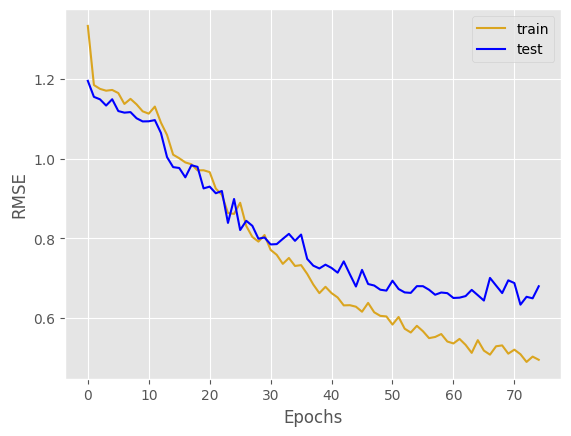

In [87]:
score_train = []
score_test = []
epochs = 75
model.reset_parameters()
for epoch in range(epochs):
    train_rmse = train()
    test_rmse = test(test_loader)
    score_train.append(train_rmse)
    score_test.append(test_rmse)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_rmse:.4f} '
          f'Test Loss: {test_rmse:.4f}')
plt.plot(range(epochs), score_train, c='goldenrod')
plt.plot(range(epochs), score_test, c = 'blue')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['train', 'test'])

## **Model Evaluation**

In [88]:
@torch.no_grad()
def eval(loader):
    output = []
    smi = []
    model.eval()
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        concatenated_data = torch.cat((out, data.y.view(-1, 1)), dim=1)
        output.append(concatenated_data)
        smi.append(data.smiles)

    # Stack the tensors along batch dimension
    stacked_output = torch.cat(output, dim=0).cpu().numpy() ## need to add .cpu().numpy() as we used GPU
    stacked_smiles = np.concatenate(smi)
    results = pd.concat([pd.DataFrame(stacked_output, columns=['pred', 'actual']), pd.DataFrame(stacked_smiles, columns=['smiles'])], axis=1)
    r2 = r2_score(results['actual'], results['pred'])
    print(f"The R2 score is {r2}")
    return results



In [89]:
test_res = eval(test_loader)

The R2 score is 0.6659750938415527


In [90]:
test_res.head()

,pred,actual,smiles
0,2.635804,1.28,CCCN(CCO)CCCOc1cc2ncnc(Nc3cc(CC(=O)Nc4cccc(F)c...
1,3.178616,3.09,OCc1ccc2ccn(c3cc(NC4CC4)n5ncc(C#N)c5n3)c2c1
2,1.050366,-1.41,CC(=O)Nc1cccc2c1c(Oc3ccc(Cl)cc3)c(C)n2CC(=O)O
3,2.273201,1.90,CN1CCCC(COc2nccc(Nc3cc(NC(=O)c4ccnc(c4)N5CCOCC...
4,3.610769,4.20,CC(C)C[C@H](CO)Nc1nc(SCc2ccccc2)nc3NC(=O)Sc13


In [91]:
np.sqrt(mean_squared_error(test_res['actual'], test_res['pred']))

0.6794363

In [92]:
train_res = eval(train_loader)

The R2 score is 0.819137454032898


In [93]:
train_res.head()

,pred,actual,smiles
0,3.645978,4.17,CCCCc1nc2c(N)nc3ccccc3c2n1Cc4ccccc4
1,3.420268,3.42,CN(C)CC\C=C\1/c2ccccc2Sc3ccc(Cl)cc13
2,1.928264,1.40,Nc1ncnc(Nc2ccccc2)n1
3,2.161643,1.60,O=C(NC1(CC1)C#N)[C@@H]2CCCC[C@H]2C(=O)N3CCN(CC...
4,3.355048,2.80,O=C1CCOc2cc(OCc3cccc(c3)C#N)ccc12


In [94]:
np.sqrt(mean_squared_error(train_res['actual'], train_res['pred']))

0.5133382

In [95]:
torch.save(model, '/home/sandeep/gnn/content/model_lipo_tuned.pth')

In [96]:
model = torch.load('/home/sandeep/gnn/content/model_lipo_tuned.pth')

/tmp/ipykernel_441696/4223125286.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/home/sandeep/gnn/content/model_lipo_tuned.pth')


## **Post-hoc Analysis**

In [97]:
test_res = eval(test_loader)

The R2 score is 0.6659750938415527


In [98]:
test_res.head()

,pred,actual,smiles
0,2.635804,1.28,CCCN(CCO)CCCOc1cc2ncnc(Nc3cc(CC(=O)Nc4cccc(F)c...
1,3.178616,3.09,OCc1ccc2ccn(c3cc(NC4CC4)n5ncc(C#N)c5n3)c2c1
2,1.050366,-1.41,CC(=O)Nc1cccc2c1c(Oc3ccc(Cl)cc3)c(C)n2CC(=O)O
3,2.273201,1.90,CN1CCCC(COc2nccc(Nc3cc(NC(=O)c4ccnc(c4)N5CCOCC...
4,3.610768,4.20,CC(C)C[C@H](CO)Nc1nc(SCc2ccccc2)nc3NC(=O)Sc13


In [99]:
train_res = eval(train_loader)

The R2 score is 0.819137454032898


In [100]:
train_res.head()

,pred,actual,smiles
0,3.009310,2.87,C[C@](O)(CS(=O)(=O)c1ccc(F)cc1)C(=O)Nc2ccc(C#N...
1,2.387595,2.00,Cc1c(Sc2ccc(Cl)cc2)c3cccc(Cl)c3n1CC(=O)O
2,0.995571,0.37,NS(=O)(=O)c1cc2c(NC(NS2(=O)=O)C(Cl)Cl)cc1Cl
3,1.959019,1.00,CN1CC(C1)n2nccc2c3cc(Cl)ccc3Oc4cc(F)c(cc4F)S(=...
4,0.249560,0.14,CCCCOc1nc(N)c2NC(=O)N(Cc3cccc(CC(=O)O)c3)c2n1


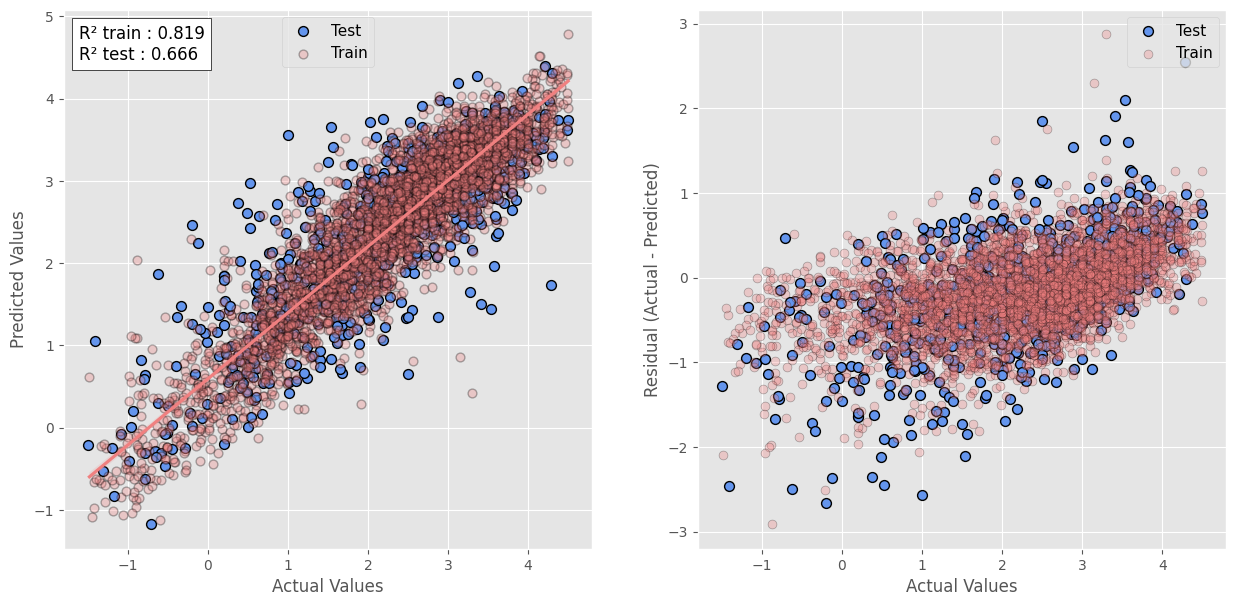

In [101]:
fig = plt.figure(figsize=(15, 7))
grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
plt.scatter(test_res['actual'],test_res['pred'], color='cornflowerblue', label='Test', linewidths=1, edgecolors='black', s=50)
sns.regplot(data = train_res, x = 'actual',y = 'pred', color='lightcoral', label='Train', scatter_kws={'s':40, 'alpha':0.3, 'edgecolor':'black'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
anchored_text = AnchoredText("R\u00b2 train : "+str(round(r2_score(train_res['actual'],train_res['pred']),3))+'\n'"R\u00b2 test : "+str(round(r2_score(test_res['actual'],test_res['pred']),3)), loc=2,prop=dict(size=12))
ax1.add_artist(anchored_text)
plt.legend(loc = 9, prop={'size': 11})
##second plot
ax2 = plt.subplot(grid[0, 1])
x = test_res['actual']
y = test_res['pred']
z= x - y
##Residual = actual y value − predicted y value

a = train_res['actual']
b = train_res['pred']
c= a - b
plt.scatter(x,z, color='cornflowerblue', label='Test', linewidths=1, edgecolors='black', s=50)
sns.scatterplot(x=a,y=c, color='lightcoral', label='Train', alpha = 0.3, s = 40,edgecolor='black')
plt.xlabel('Actual Values')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend(loc='upper right', prop={'size': 11})
# plt.savefig('reg.tiff', dpi=300, bbox_inches = "tight")


In [102]:
test_res.head()

,pred,actual,smiles
0,2.635804,1.28,CCCN(CCO)CCCOc1cc2ncnc(Nc3cc(CC(=O)Nc4cccc(F)c...
1,3.178616,3.09,OCc1ccc2ccn(c3cc(NC4CC4)n5ncc(C#N)c5n3)c2c1
2,1.050366,-1.41,CC(=O)Nc1cccc2c1c(Oc3ccc(Cl)cc3)c(C)n2CC(=O)O
3,2.273201,1.90,CN1CCCC(COc2nccc(Nc3cc(NC(=O)c4ccnc(c4)N5CCOCC...
4,3.610768,4.20,CC(C)C[C@H](CO)Nc1nc(SCc2ccccc2)nc3NC(=O)Sc13


In [103]:
##To calculate the absolute error
test_res['abs_error'] = abs(test_res['actual'] - test_res['pred'])

In [104]:
test_res.head()

,pred,actual,smiles,abs_error
0,2.635804,1.28,CCCN(CCO)CCCOc1cc2ncnc(Nc3cc(CC(=O)Nc4cccc(F)c...,1.355804
1,3.178616,3.09,OCc1ccc2ccn(c3cc(NC4CC4)n5ncc(C#N)c5n3)c2c1,0.088616
2,1.050366,-1.41,CC(=O)Nc1cccc2c1c(Oc3ccc(Cl)cc3)c(C)n2CC(=O)O,2.460366
3,2.273201,1.90,CN1CCCC(COc2nccc(Nc3cc(NC(=O)c4ccnc(c4)N5CCOCC...,0.373201
4,3.610768,4.20,CC(C)C[C@H](CO)Nc1nc(SCc2ccccc2)nc3NC(=O)Sc13,0.589232


In [105]:
##Look highest 8 abs error from the database
test_res = test_res.sort_values('abs_error', ascending=False)
mols = [Chem.MolFromSmiles(x) for x in test_res['smiles'][:8]]

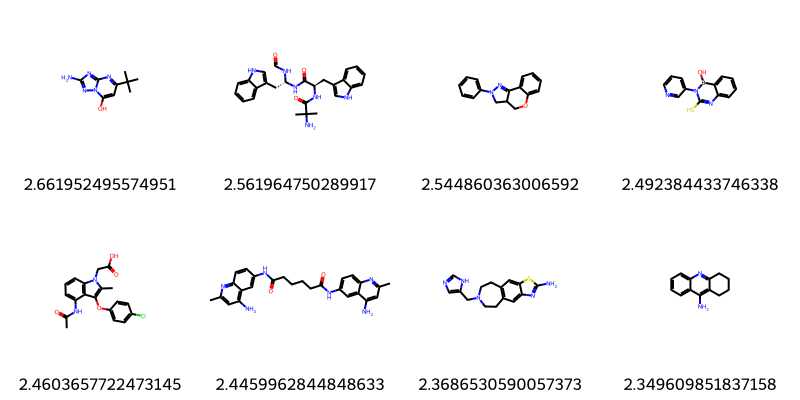

In [106]:
img=Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(200,200),legends=[str(x) for x in test_res['abs_error']])
img

In [107]:
test_res.tail(8)

,pred,actual,smiles,abs_error
153,2.178715,2.17,Cc1nc(cs1)C(=O)N2CCOC3(CCN(Cc4ccc(Cl)cc4)CC3)C2,0.008715
821,3.507118,3.50,COc1cc(ccc1Nc2ncc(Cl)c(n2)c3cnc4c(F)cccn34)N5C...,0.007118
360,1.833879,1.84,Clc1ccc(CN2CCNCC2)cc1C(=O)NCC34CC5CC(CC(C5)C3)C4,0.006121
368,2.422077,2.42,Cc1cc(Cl)ccc1OC2CCN(C[C@H](O)CNC(=O)C3=CNC(=O)...,0.002077
293,3.198455,3.20,N(c1ccccc1)c2ccccc2,0.001545
486,3.251191,3.25,C[C@H]1C[C@H]2[C@@H]3CC[C@H](C(=O)C)[C@@]3(C)C...,0.001191
270,2.299795,2.30,COc1ccc(nc1OC)N2CCN([C@H](C)C2)C(=O)[C@@H]3CCC...,0.000205
34,3.249861,3.25,Cc1cc(NC(=O)c2ccc(Cl)cc2)n(n1)c3ccccc3,0.000139


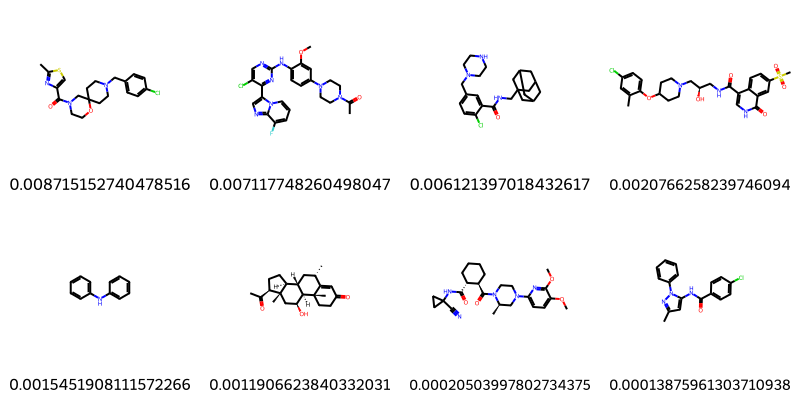

In [108]:
##Look minimum 8 abs error from the database
mols = [Chem.MolFromSmiles(x) for x in test_res['smiles'][-8:]]
img=Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(200,200),legends=[str(x) for x in test_res['abs_error'][-8:]])
img

In [109]:
##Actual/exact error
test_res['error'] = test_res['actual'] - test_res['pred']

In [110]:
test_res.head()

,pred,actual,smiles,abs_error,error
607,2.461952,-0.20,CC(C)(C)c1cc(O)n2nc(N)nc2n1,2.661952,-2.661952
252,3.561965,1.00,CC(C)(N)C(=O)N[C@H](Cc1c[nH]c2ccccc12)C(=O)N[C...,2.561965,-2.561965
414,1.735140,4.28,C1Oc2ccccc2C3=NN(CC13)c4ccccc4,2.544860,2.544860
748,1.872385,-0.62,OB1N(C(=Nc2ccccc12)S)c3cccnc3,2.492384,-2.492384
2,1.050366,-1.41,CC(=O)Nc1cccc2c1c(Oc3ccc(Cl)cc3)c(C)n2CC(=O)O,2.460366,-2.460366


<Axes: xlabel='error', ylabel='Count'>

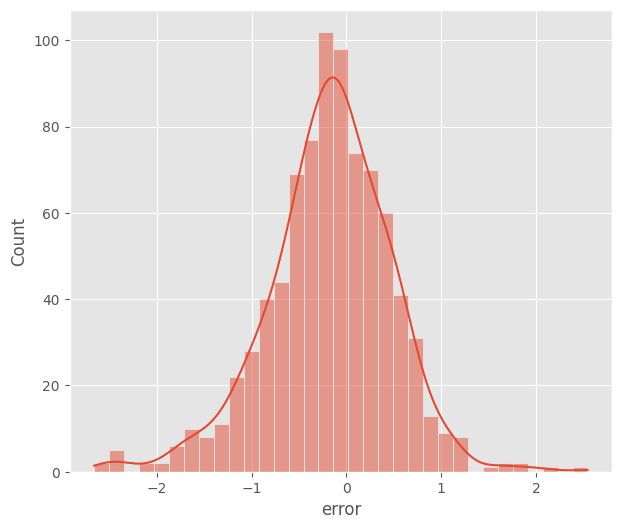

In [111]:
fig = plt.figure(figsize=(7, 6))

sns.histplot(test_res, x='error', kde=True) ##kde kernal density estimation line
